In [426]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  5 10:41:27 2020
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

def time2semichord(time, U, chord):
    return 2*U*time/chord

def semichord2time(s, U, chord):
    return s/2/U*chord

# determining X and Y terms for recursive marching formula for approximation of Duhamel's integral 
def duhamel_approx(Xi,Yi,delta_s,delta_alpha,order=2,A1=0.3,A2=0.7,b1=0.14,b2=0.53):
    # A1=0.165,A2=0.335,b1=0.0455,b2=0.3
    # determine the next values of X and Y, named Xip1 and Yip1
    if order==1:
        Xip1= Xi*np.exp(-b1*delta_s)+A1*delta_alpha
        Yip1= Yi*np.exp(-b2*delta_s)+A2*delta_alpha
    elif order==2:
        Xip1= Xi*np.exp(-b1*delta_s)+A1*delta_alpha*np.exp(-b1*delta_s/2)
        Yip1= Yi*np.exp(-b2*delta_s)+A2*delta_alpha*np.exp(-b2*delta_s/2)        
    else:
        Xip1= Xi*np.exp(-b1*delta_s)+A1*delta_alpha*((1+4*np.exp(-b1*delta_s/2)+np.exp(-b1*delta_s))/6)
        Yip1= Yi*np.exp(-b2*delta_s)+A2*delta_alpha*((1+4*np.exp(-b2*delta_s/2)+np.exp(-b2*delta_s))/6)
    
    return Xip1,Yip1

# define function for circulatory force, potential flow
def circulatory_normal_force(dCn_dalpha,alpha_equivalent,alpha0):
    return dCn_dalpha*(alpha_equivalent-alpha0)

# deficiency function for non-circulatory normal force
def deficiency_function(Dnoncirc_i,delta_dalpha_dt,delta_t,chord,asound=343,kalpha=0.75):
    # a sound is the speed of sound
    TI=chord/asound
    Dnoncirc_ip1 = Dnoncirc_i*np.exp(-delta_t/(kalpha*TI))+delta_dalpha_dt*np.exp(-delta_t/(2*kalpha*TI))
    return Dnoncirc_ip1

# non-circulatory normal force
def non_circulatory_normal_force(dalpha_dt,chord,Uinf,Dnoncirc,kalpha=0.75):
    return 4*kalpha*chord/Uinf*(dalpha_dt-Dnoncirc)
    
# definition of a function for the trailing edge separation point "f"
def f_trailing_edge_separation_point(alpha, a1=7,a2=15,a3=21):
    # receives alpha in radians, converts to degrees
    alphadeg = alpha*180/np.pi
    if alphadeg<=a1:
        f=1
    elif ((alphadeg>a1) and (alphadeg<=a2)):
        f= 1 - .8*((alphadeg-a1)/(a2-a1))
    elif ((alphadeg>a2) and (alphadeg<a3)):
        f= .2 *(1- ((alphadeg-a2)/(a3-a2))**.3)
    else:
        f=0
    return f

# we will now determine the effect of the pressure lag in terms of onset of the separation point
def pressure_lag_deficiency(Dpress_i,delta_s, delta_CNpot, Tp=1.7):
    return Dpress_i*np.exp(-delta_s/Tp)+ delta_CNpot*np.exp(-delta_s/2/Tp) 

## we will now implement a delay function for separation point for boundary layer lag effects
def boundary_layer_lag_deficiency(Dbl_i,delta_s, delta_fprime, Tf=3.0):
    return Dbl_i*np.exp(-delta_s/Tf)+ delta_fprime*np.exp(-delta_s/2/Tf) 

# we will now setup the non-dimensional vortex-time parameter vortime
# we will setup an equation for vortime, integrating in time
def vortime_function(vortime_i,delta_s,delta_alphaqs, Cnormal_prime, CN1=1.0093):
    if Cnormal_prime>CN1:
        vortime_ip1 = vortime_i + 0.45*delta_s
    else:
        if (delta_alphaqs<0 and vortime_i>0):
            vortime_ip1 = vortime_i + 0.45*delta_s
        else:
            vortime_ip1 = 0 
    
    return vortime_ip1

# we will now define the function for decay of the cumulative normal force due to the presence of the leading edge vortex
def leading_edge_vortex_normal_force(Cnormal_vortex_i,delta_s,delta_Cvortex,vortime,TVL=11,TV=6):
    if (vortime>0.001 and vortime<TVL):
        Cnormal_vortex_ip1=Cnormal_vortex_i*np.exp(-delta_s/TV)+ delta_Cvortex*np.exp(-delta_s/2/TV)      
    else:    
        Cnormal_vortex_ip1=Cnormal_vortex_i*np.exp(-delta_s/TV) 
    return Cnormal_vortex_ip1

def pitt_peters(Ct,vind,Uinf,R,dt,glauert=True ):
    # this function determines the time derivative of the induction at the annulli 
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow, nd dt is the time step
    # it returns the new value of induction vindnew and the time derivative dvind_dt
    # glauert defines if glauert's high load correction is applied
    a=-vind/Uinf # determine the induction coefficient for the time step {i-1}
    Ctn= -CTfunction(a, glauert) # calculate the thrust coefficient from the induction for the time step {i-1}
    dvind_dt =  (Ct-Ctn)/(16/(3*np.pi))*(Uinf**2/R) # calculate the time derivative of the induction velocity
    vindnew = vind + dvind_dt*dt # calculate the induction at time {i} by time integration
    return vindnew, dvind_dt

def oye_dynamic_inflow(vz, Ct1, Ct2, vint, Uinf, R, r,dt,glauert=True):
    # this function determines the time derivative of the induction at the annulli
    # using the Øye dynamic inflow model
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # r is the radial position of the annulus. vqs is the quasi-steady value from BEM, 
    #vint is an intermediate value and vz is the induced velocity
    
    # calculate  quasi-steady induction velocity
    vqst1=-ainduction(-Ct1)*Uinf

    # calculate current induction factor
    a=-vz/Uinf

    # calculate time scales of the model
    t1 = 1.1/(1-1.3*a)*R/Uinf
    t2 = (0.39-0.26*(r/R)**2)*t1

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
        
    #calculate time derivative of intermediate velocity
    dvint_dt= (vqst1+ (vqst2-vqst1)/dt*0.6*t1 - vint)/t1

    # calculate new intermediate velocity
    vint2 = vint +dvint_dt*dt
    
    #calculate time derivaive of the induced velocity
    dvz_dt = ((vint+vint2)/2-vz)/t2
    
    #calculate new induced velocity
    vz2 = vz +dvz_dt*dt
    
    return vz2, vint2

def larsenmadsen(vz, Ct2, Uinf, R,dt,glauert=True):
    # this function determines the time derivative of the induction at the annulli
    # using the Larsen-Madsen dynamic inflow model
    # Ct2 is the thrust coefficient on the actuator at the next time step, 
    # vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # R is the radius. vqst2 is the quasi-steady value from momentum theory, 
    
    # calculate velocity wake 
    Vwake=Uinf+vz

    # calculate time scales of the model
    t1 = 0.5*R/Vwake

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
    
    #calculate new induced velocity
    vz2 = vz*np.exp(-dt/t1)+vqst2*(1-np.exp(-dt/t1))
    
    return vz2

def CTfunction(a, glauert = True):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot


In [502]:

def loadBladeElement(j, time, alpha_time, s_time, X_time, Y_time, alpha_eq_time, Dnoncirc_time,
                     Cnormal_p_time, Dpress_time, Cnormal_prime_time, fprime_time, Dbl_time, 
                     vor_time, Cvortex_time, Cnormal_vortex_time, 
                     vnorm, vtan, r_R, chord, twist, 
                     polar_alpha, 
                     polar_cl, polar_cd, 
                     dyn_stall=False, leading_edge=False):
    """
    calculates the load in the blade element
    """
    # inputs from assignment
    dCn_da = 2*np.pi # lift curve slope
    alpha0 = -1.9457*np.pi/180 # zero lifting angle in radians from DU_polar.txt
    
    vmag2 = vnorm**2 + vtan**2
    Uinf = np.sqrt(vmag2)
    inflowangle = np.arctan2(vnorm,vtan)
    # still in degrees
    alpha = twist + inflowangle*180/np.pi
    alpha_time[j] = alpha
    # only enter dynamic stall module if the user wants it and the first time step
    # has been evaluated
    
    if dyn_stall and (j!=0):
        # everything in radians in the dynamic stall module
#         print(alpha_time)
        dt = time[1]-time[0]
        # calculate quasi-steady angle of attack
        alphaqs = alpha_time*np.pi/180
        dalphaqs_dt = np.zeros(len(alphaqs))
        dalphaqs_dt[0] = (alphaqs[1]-alphaqs[0])/dt
        dalphaqs_dt[1:] = np.diff(alphaqs)/dt
        
        # determine s - number of semi-chords we have travelled so far
        s = time2semichord(dt, U=Uinf, chord=chord)
#         sarray = time2semichord(time, U=Uinf, chord=chord)
        s_time[j] = s_time[j-1] + s # add the current semi-chord travelled to the array
        
        # determine alpha equivalent
        X,Y=duhamel_approx(X_time[j-1],Y_time[j-1], s_time[j]-s_time[j-1],
                                                   (alphaqs[j]-alphaqs[j-1]))
        alpha_eq = alphaqs[j]-X-Y
        alpha_eq_time[j] = alpha_eq
        # determine deficiency function for non-circulatory loading

        Dnoncirc=deficiency_function(Dnoncirc_time[j-1],dalphaqs_dt[j]-dalphaqs_dt[j-1],
                                            dt,chord)
        Cnormal_circ = circulatory_normal_force(dCn_da,alpha_eq,alpha0)
        Cnormal_noncirc =  non_circulatory_normal_force(dalphaqs_dt[j],chord,Uinf,Dnoncirc)
        Cnormal_p = Cnormal_circ+Cnormal_noncirc

        # Cnormal_p in time vector 
        Cnormal_p_time[j] = Cnormal_p
        
        # BEGIN TRAILING EDGE SEPARATION MODULE
        # determine pressure lag deficiency
        # we will now solve the pressure lag deficiency function based on historical pressure lag
        Dpress = pressure_lag_deficiency(Dpress_time[j-1],s_time[j]-s_time[j-1], 
                                                Cnormal_p_time[j]-Cnormal_p_time[j-1])
        
        # determine Cnprime
        Cnormal_prime = Cnormal_p-Dpress
        # and based on this Cnormal_prime, we determine a new equivalent angle of attack 
        # to determine the onset of trailing edge separation
        alpha_f = Cnormal_prime/dCn_da+alpha0

        # we use this equivalent angle of attack alpha_f to determine a new trailign edge separation point effect f_prime
        fprime  = f_trailing_edge_separation_point(alpha_f)
        #store fprime in time vector
        fprime_time[j] = fprime
        
        # we need to define an array for the boundary layer lag deficiency function
        # we will now solve for the boundary layer lag deficiency function 

        Dbl = boundary_layer_lag_deficiency(Dbl_time[j-1],s_time[j]-s_time[j-1], 
                                               fprime_time[j]-fprime_time[j-1])

        # we now determine the a new expression of fprimeprime due to the boundary layer lag
        fprimeprime = fprime-Dbl

        # we can now determine the normal force due to trailing edge boundary layer separation
        Cnormal_f = dCn_da*((1+np.sqrt(fprimeprime))/2)**2*(alpha_eq-alpha0)+ Cnormal_noncirc
        # END OF TRAILING EDGE SEPARATION MODULE
        
        # START LEADING EDGE SEPARATION MODULE
        # we need to define vortex-time parameter vortime
        # we will now do the time marching to solve for the non-dimensional vortex-time parameter vortime
#         if r_R < 0.24408585 and r_R > 0.24408581:
#             print(vor_time[j-1],s_time[j]-s_time[j-1],alphaqs[j]-alphaqs[j-1],Cnormal_prime_time[j-1])
        vor = vortime_function(vor_time[j-1],s_time[j]-s_time[j-1],
                               alphaqs[j]-alphaqs[j-1], Cnormal_prime_time[j-1])

        # determine the increment in normal force due tot he presence of a vertex
        Cvortex=Cnormal_circ*(1 - ( ((1+np.sqrt(fprimeprime))/2)**2  ) )

        # We will now solve for the cumulative normal force due to the leadign edge vortex by marching in time.
        if j==1:
            Cnormal_vortex_time[0]=Cvortex

#         Cnormal_vortex = leading_edge_vortex_normal_force(Cnormal_vortex_time[j-1],s_time[j]-s_time[j-1], 
#                                                                 Cvortex_time[j]-Cvortex_time[j-1],vor_time[j])
        Cnormal_vortex = leading_edge_vortex_normal_force(Cnormal_vortex_time[j-1],s_time[j]-s_time[j-1], 
                                                        Cvortex-Cvortex_time[j-1],vor)

        Cnormal_total = Cnormal_f + Cnormal_vortex
        #  END OF LEADING EDGE SEPARATION MODULE
#         cl = Cnormal_total
        if leading_edge:
            cl = Cnormal_total # account for all modules including leading edge separation
        else:
            # only trailing edge separation, which ends at Cnormal_f
            # ASK: DO WE HAVE TO SET ALPHA = ALPHA_EQ?????
#             alpha = alpha_eq*180/np.pi
            # change parameters here to change the outcome!!!
#             cl = circulatory_normal_force(dCn_da,alpha_eq_time[j],alpha0) # steady polar
#             cl = Cnormal_p # only account for non-circulatory loading
            cl = Cnormal_f # account for trailing edge separation module

        test_var = cl
    else:
#         cl = circulatory_normal_force(dCn_da,alpha*np.pi/180,alpha0)
        
        fprime  = f_trailing_edge_separation_point(alpha*np.pi/180)
        cl = dCn_da*((1+np.sqrt(fprime))/2)**2*(alpha*np.pi/180-alpha0)

#         cl = np.interp(alpha, polar_alpha, polar_cl)
        s = 0
        X,Y = 0,0
        alpha_eq = alpha*np.pi/180
        Dnoncirc = 0
        Cnormal_p = cl
        Dpress = 0
        Cnormal_prime = cl
        fprime  = f_trailing_edge_separation_point(alpha*np.pi/180)
        Dbl = 0
        vor = 0
        Cvortex = 0
        Cnormal_vortex = 0
        Cnormal_total = cl
        test_var = cl
        
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return [fnorm , ftan, alpha, s, X, Y, Dnoncirc, Cnormal_p, Dpress, Cnormal_prime, 
            fprime, Dbl, vor, Cvortex, Cnormal_vortex, 
            test_var]

def solveStreamtube(time, U_time, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades,
                    chord, twist, polar_alpha, polar_cl, polar_cd, model='steady',
                   dyn_stall=False, leading_edge=False, weight=0.05):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    #find the value for dt
    if len(time)==1:
        dt=1
    else:
        dt = time[1]-time[0]
    
    # initiatlize variables
    a = 0.0 # axial induction
    aline = 0.0 # tangential induction factor
    
    Niterations = 500  
    weight = 0.05
    Erroriterations =0.00001*dt*weight #relative change in induction factor

    # define empty arrays that will house the results in time
    a_time = np.zeros(len(time))
    ap_time = np.zeros(len(time))
    alpha_time = np.zeros(len(time))
    fnorm_time = np.zeros(len(time))
    ftan_time = np.zeros(len(time))
    Ct_time = np.zeros(len(time))
    s_time = np.zeros(len(time))
    X_time = np.zeros(len(time))
    Y_time = np.zeros(len(time))
    alpha_eq_time = np.zeros(len(time))
    Dnoncirc_time = np.zeros(len(time))
    Cnormal_p_time = np.zeros(len(time))
    Dpress_time = np.zeros(len(time))
    Cnormal_prime_time = np.zeros(len(time))
    fprime_time = np.zeros(len(time))
    Dbl_time = np.zeros(len(time))
    vor_time = np.zeros(len(time))
    Cvortex_time = np.zeros(len(time))
    Cnormal_vortex_time = np.zeros(len(time))
    test_var_time = np.zeros(len(time))
    
    for j in range(len(time)):
        Uinf = U_time[j]
        if j==0:
            stored_model = model
            model = 'steady'
        elif j==1:
            model=stored_model
            
            if model == 'oye':
                vint = -a_time[0]*U_time[0]*Prandtl
            
        for i in range(Niterations):
            
            # calculate velocity and loads at blade element
            Urotor = Uinf*(1-a) # axial velocity at rotor
            Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
            # calculate loads in blade segment in 2D (N/m)
            [fnorm, ftan, alpha, s, X, Y, Dnoncirc, Cnormal_p, Dpress, Cnormal_prime, fprime, 
             Dbl, vor, Cvortex, Cnormal_vortex, 
             test_var] = loadBladeElement(j, time, alpha_time, s_time, X_time, Y_time, 
                                          alpha_eq_time, Dnoncirc_time, Cnormal_p_time, 
                                          Dpress_time, Cnormal_prime_time, fprime_time, Dbl_time, 
                                          vor_time, Cvortex_time,Cnormal_vortex_time, 
                                          Urotor, Utan, r_R,chord, twist, 
                                          polar_alpha, polar_cl, polar_cd, dyn_stall, leading_edge)
            load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction

            # // calculate thrust coefficient at the streamtube 
            CT = load3Daxial/(0.5*Area*Uinf**2)

            # applies the relevant model to the analysis
            if model == 'steady':
                # calculate new axial induction, accounting for Glauert's correction
                anew =  ainduction(CT)
            else:
                if model == 'pitt_peters':
                    vind,dvind_dt = pitt_peters(np.array([-CT]),np.array([-a_time[j-1]*U_time[j-1]*Prandtl]),U_time[j],Radius,dt)
                elif model == 'oye':
                    vind,vint_new=oye_dynamic_inflow(np.array([-a_time[j-1]*U_time[j-1]*Prandtl]), np.array([-Ct_time[j-1]]), np.array([-CT]), vint, U_time[j], Radius, r_R*Radius,dt) 
                elif model == 'larsen_madsen':
                    vind = larsenmadsen(np.array([-a_time[j-1]*U_time[j-1]*Prandtl]), np.array([-CT]), U_time[j], Radius,dt)
                else:
                    raise ValueError('Model not recognized')
                #find the new axial induction factor 
                anew = -vind[0]/U_time[j]

            # correct new axial induction with Prandtl's correction
            Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R,tipradius_R, Omega*Radius/Uinf, NBlades, anew);
            if (Prandtl < 0.0001): 
                Prandtl = 0.0001 # avoid divide by zero
            anew = anew/Prandtl # correct estimate of axial induction
            prev_a = 1*a
            
            if model != 'steady':
                # a=anew if we are using a dynamic inflow model
                # used to speed up the iteration
                weight=0.6
            a = (1-weight)*a+weight*anew # for improving convergence, weigh current and previous iteration of axial induction

            # calculate aximuthal induction
            aline_new = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
            aline_new =aline_new/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
            
            # set aline instantly for speed purposes
            if model != 'steady':
                aline = 0.0*aline+1.*aline_new
            else:
                aline = 0.85*aline+0.15*aline_new

            #// test convergence of solution, by checking convergence of axial induction
            if (np.abs((a-anew)/a) < Erroriterations):
                break
                
        # save the results of the iteration
        a_time[j] = a
        ap_time[j] = aline
        alpha_time[j] = alpha
        fnorm_time[j] = fnorm
        ftan_time[j] = ftan
        Ct_time[j] = CT
        s_time[j] = s if j==0 else s_time[j-1]+s
        X_time[j] = X
        Y_time[j] = Y
#         alpha_eq_time
        Dnoncirc_time[j] = Dnoncirc
        Cnormal_p_time[j] = Cnormal_p
        Dpress_time[j] = Dpress
        Cnormal_prime_time[j] = Cnormal_prime
        fprime_time[j] = fprime
        Dbl_time[j] = Dbl
        vor_time[j] = vor
        Cvortex_time[j] = Cvortex
        Cnormal_vortex_time[j] = Cnormal_vortex
        test_var_time[j] = test_var
    if i == Niterations-1:
        print('WARNING: BEM model did not converge within {} iterations, consider increasing iteration amount.'.format(Niterations))
    return [a_time , ap_time, alpha_time, fnorm_time, ftan_time, Ct_time, test_var_time]




In [444]:
class unsteady_BEM:
    def __init__(self, airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, TSR, N_blade_sec, spacing = 'cosine'):
        self.airfoil = airfoil
        self.NBlades = NBlades
        self.Radius = Radius
        self.Omega = TSR*Uinf/Radius
        self.N_blade_sec = N_blade_sec
        self.RootLocation_R = RootLocation_R
        self.TipLocation_R = TipLocation_R
        #create the blade division
        if spacing == 'cosine':
            beta_cosine = np.linspace(0,np.pi,N_blade_sec+1)
            self.r_R_dist = RootLocation_R+(TipLocation_R-RootLocation_R)/2*(1-np.cos(beta_cosine))
        elif spacing == 'uniform':
            self.r_R_dist = np.linspace(RootLocation_R,TipLocation_R,N_blade_sec+1)
        else:
            raise ValueError('Spacing method not recognized, please select either "cosine" or "uniform"')
        
        self.r_R_cent = np.zeros(N_blade_sec)
        #get the normalized radial locations of the blade sections
        for i in range(N_blade_sec):
            self.r_R_cent[i] = (self.r_R_dist[i]+self.r_R_dist[i+1])/2
        #define the twist distribution without pitch as well as the chord distribution
        self.twist_no_pitch = -14*(1-self.r_R_cent)
        self.chord_cent = 3*(1-self.r_R_cent)+1
        
        #read in the polar of the airfoil
        data1=pd.read_csv(airfoil, header=0,
                            names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
        self.polar_alpha = data1['alfa'][:]
        self.polar_cl = data1['cl'][:]
        self.polar_cd = data1['cd'][:]
        #initialize the CT as a function of the pitch
    
    #function to get the results of the steady BEM given a pitch angle            
    def get_solution(self, time, U_time, pitch, model='steady', dyn_stall=False, 
                     leading_edge=False,weight=0.05):
        
        #add the pitch to the twist
        self.twist_cent = self.twist_no_pitch+pitch
        
        # define empty arrays that will house the results in time
        a_res= np.zeros([self.N_blade_sec, len(time)])
        ap_res = np.zeros([self.N_blade_sec, len(time)])
        alpha_res = np.zeros([self.N_blade_sec, len(time)])
        fnorm_res = np.zeros([self.N_blade_sec, len(time)])
        ftan_res = np.zeros([self.N_blade_sec, len(time)])
        Ct_res = np.zeros([self.N_blade_sec, len(time)])
        test_var_res = np.zeros([self.N_blade_sec, len(time)])
        
        # define empty arrays for thrust and power coefficient calculation
        T_res = np.zeros([self.N_blade_sec, len(time)])
        M_res = np.zeros([self.N_blade_sec, len(time)])
        
        #find the width of each blade section
        dr = (self.r_R_dist[1:]-self.r_R_dist[:-1])*self.Radius
        
        #solve each Streamtube in time
        for i in range(self.N_blade_sec):
            [a_res[i,:], ap_res[i,:], alpha_res[i,:], fnorm_res[i,:], ftan_res[i,:], 
             Ct_res[i,:], test_var_res[i,:]] = solveStreamtube(time, U_time, self.r_R_dist[i], self.r_R_dist[i+1], 
                   self.RootLocation_R, self.TipLocation_R , self.Omega, self.Radius, self.NBlades, 
                   self.chord_cent[i], self.twist_cent[i], self.polar_alpha, self.polar_cl, self.polar_cd,
                                            model, dyn_stall, leading_edge, weight)
            #save the absolute value for thrust and moment for each blade section
            T_res[i,:] = fnorm_res[i,:]*dr[i]
            M_res[i,:] = ftan_res[i,:]*dr[i]*self.r_R_cent[i]*self.Radius
            #print progress
            clear_output(wait=True)
            print('we are at {}%'.format(round(i/self.N_blade_sec, 2)*100))

        #calculate the CT and CP
        areas = (self.r_R_dist[1:]**2-self.r_R_dist[:-1]**2)*np.pi*self.Radius**2
        dr = (self.r_R_dist[1:]-self.r_R_dist[:-1])*self.Radius
        #sum all the values for thrust and moment along axis=0 to find the total thrust in time and normalize
        CT_res = np.sum(T_res,axis=0)*self.NBlades/(0.5*U_time**2*np.pi*self.Radius**2)
        CP_res = np.sum(M_res,axis=0)*self.NBlades*self.Omega/(0.5*U_time**3*np.pi*self.Radius**2)
        return [a_res, ap_res, alpha_res, fnorm_res, ftan_res, Ct_res, CT_res, CP_res, test_var_res]



In [445]:
# define flow conditions
Uinf = 10 # unperturbed wind speed in m/s
TSR = 8 # tip speed ratio
Radius = 50
N_blade_sec = 30
NBlades = 3

TipLocation_R =  1
RootLocation_R =  0.2
pitch = 2

airfoil = 'DU_polar.txt'

B = unsteady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, TSR, N_blade_sec)
results = B.get_solution(np.array([0]), np.array([Uinf]), pitch)
print('CT: {}'.format(round(results[6][0], 5)))
print('CP: {}'.format(round(results[7][0], 5)))
    

we are at 97.0%
CT: 0.64488
CP: 0.4439


# Case Dyn 1

In [486]:
#create the time array
Uinf = 10 # unperturbed wind speed in m/s
max_time = 25 #upper bound on the time vector
dt = 0.1
time = np.arange(0,max_time,dt)
U1_U0 = 1.0
deltaU = 0.5
omega_r_uinf = 0.
azimuth = TSR*Uinf/Radius*time
U_time = np.zeros(len(time)) + Uinf*U1_U0 + deltaU*np.cos(omega_r_uinf*time)*np.cos(azimuth)



In [529]:
import time as tm
#1.1 Demonstrate a fully developed cycle for case Dyn 1 
#ending ds=dynamic stall
model='pitt_peters'
dyn_stall = True
leading_edge = True
[a_res_pp_ds, ap_res_pp_ds, alpha_res_pp_ds, fnorm_res_pp_ds, ftan_res_pp_ds, Ct_res_pp_ds, 
 CT_res_pp_ds, CP_res_pp_ds, test_res_pp_ds] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)

#1.1.1 Compare with the loads assuming a steady  polar, and discuss the results
#ending sp=steady polar
model = 'pitt_peters'
dyn_stall = False
leading_edge = False
[a_res_pp_sp, ap_res_pp_sp, alpha_res_pp_sp, fnorm_res_pp_sp, ftan_res_pp_sp, Ct_res_pp_sp, 
 CT_res_pp_sp, CP_res_pp_sp, test_res_pp_sp] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)

#1.1.2 Compare with the loads assuming that there is no leading edge separation, 
#and discuss the results
#end nles=no leading edge separation
model='pitt_peters'
dyn_stall = True
leading_edge=False
[a_res_pp_nles, ap_res_pp_nles, alpha_res_pp_nles, fnorm_res_pp_nles, ftan_res_pp_nles, 
 Ct_res_pp_nles, CT_res_pp_nles, CP_res_pp_nles, 
 test_res_pp_nles] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)

# As a check, run the analysis for a steady BEM code.
model='steady'
dyn_stall = False
leading_edge = False
[a_res_s, ap_res_s, alpha_res_s, fnorm_res_s, ftan_res_s, Ct_res_s, CT_res_s, 
 CP_res_s, test_res_s] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)


we are at 97.0%


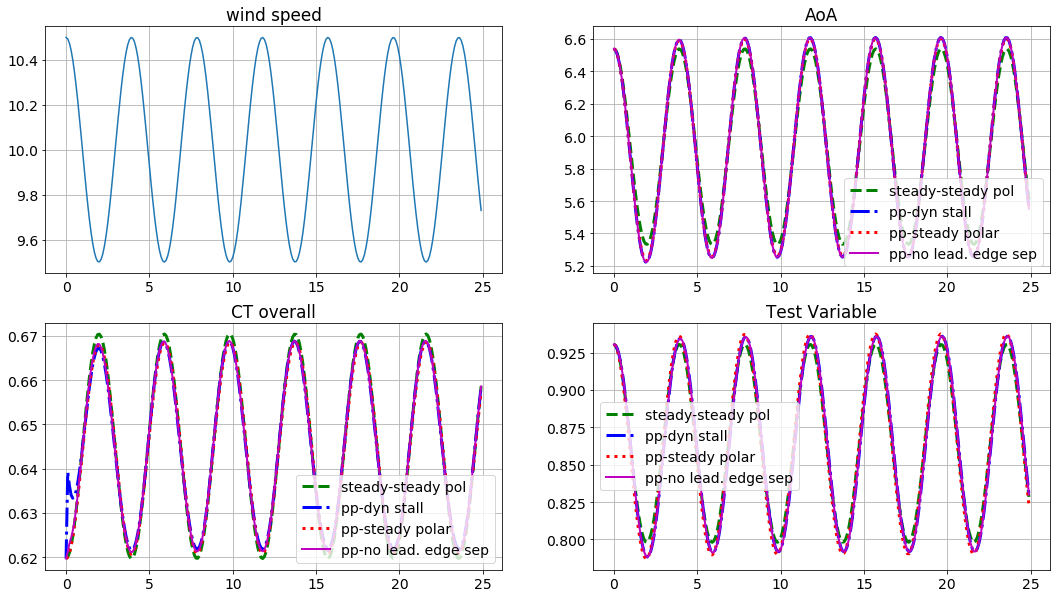

In [532]:
l = 12

show_cp = False
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 14}) 
fig, axs = plt.subplots(2,2, figsize=(18,10))
axs[0,0].plot(time, U_time)
axs[0,0].set_title('wind speed')

axs[0,1].set_title('AoA')
axs[0,1].plot(time, alpha_res_s[l,:], linestyle='--', linewidth=3, color='g', label='steady-steady pol')
axs[0,1].plot(time, alpha_res_pp_ds[l,:], linestyle='-.', linewidth=3, color='b', label='pp-dyn stall')
axs[0,1].plot(time, alpha_res_pp_sp[l,:], linestyle=':', linewidth=3, color='r', label='pp-steady polar')
axs[0,1].plot(time, alpha_res_pp_nles[l,:], linestyle='-', linewidth=2, color='m', label='pp-no lead. edge sep')
# axs[0,1].set_ylim([0.4, 1.0])
axs[0,1].legend(loc='lower right')

axs[1,0].set_title('CT overall')
axs[1,0].plot(time, CT_res_s, linestyle='--', linewidth=3, color='g', label='steady-steady pol')
axs[1,0].plot(time, CT_res_pp_ds, linestyle='-.', linewidth=3, color='b', label='pp-dyn stall')
axs[1,0].plot(time, CT_res_pp_sp, linestyle=':', linewidth=3, color='r', label='pp-steady polar')
axs[1,0].plot(time, CT_res_pp_nles, linestyle='-', linewidth=2, color='m', label='pp-no lead. edge sep')
# axs[1,0].set_ylim([0.6, 0.7])
axs[1,0].legend(loc='lower right')

axs[1,1].set_title('Test Variable')
axs[1,1].plot(time, test_res_s[l,:], linestyle='--', linewidth=3, color='g', label='steady-steady pol')
axs[1,1].plot(time, test_res_pp_ds[l,:], linestyle='-.', linewidth=3, color='b', label='pp-dyn stall')
axs[1,1].plot(time, test_res_pp_sp[l,:], linestyle=':', linewidth=3, color='r', label='pp-steady polar')
axs[1,1].plot(time, test_res_pp_nles[l,:], linestyle='-', linewidth=2, color='m', label='pp-no lead. edge sep')
# axs[1,1].set_ylim([9, 12])
axs[1,1].legend()

In [433]:
test_res_pp_ds[l,:]/np.pi*180
1-( ((1+np.sqrt(0.7))/2)**2  ) 
test_res_pp_ds[l,:]

array([1.11708546, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

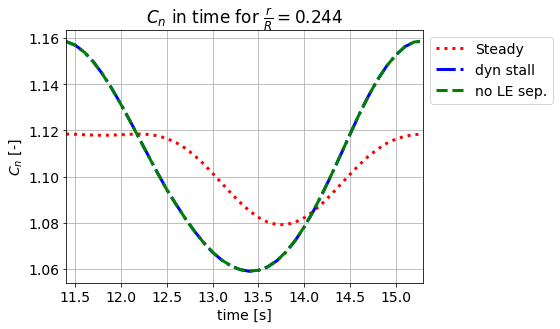

In [505]:
l = 4
i1 = 114
i2 = 154

plt.figure(figsize = [8, 4.8])
plt.plot(time[i1:i2], test_res_pp_sp[l,i1:i2], linestyle=':', linewidth=3, color='r', label='Steady')
plt.plot(time[i1:i2], test_res_pp_ds[l,i1:i2], linestyle='-.', linewidth=3, color='b', label='dyn stall')
plt.plot(time[i1:i2], test_res_pp_nles[l,i1:i2], linestyle='--', linewidth=3, color='g', label='no LE sep.')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim([time[i1],time[i2-1]])
plt.xlabel(r'time [s]')
plt.ylabel(r'$C_n$ [-]')
plt.title(r'$C_n$ in time for $\frac{{r}}{{R}} = {}$'.format(np.round(B.r_R_cent[l],3)))
plt.tight_layout()
plt.savefig('results_case2/Cn_t_ann_{}.pdf'.format(l))


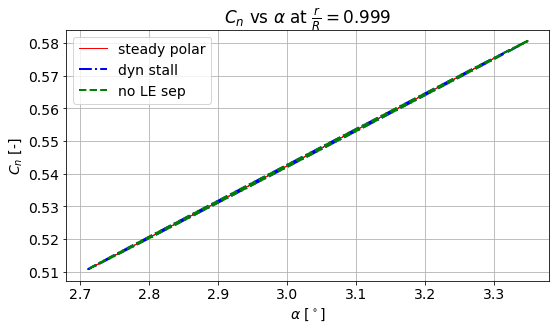

In [526]:
"""

NOTE: test variable should be set to cl for this plot to work

"""

l = 29

plt.figure(figsize = [8, 4.8])
# plt.plot(alpha_res_s[l,int(len(alpha_res_s)/2):],test_res_s[l,int(len(alpha_res_s)/2):],linestyle='--', linewidth=3, color='g', label='steady-steady pol')
plt.plot(alpha_res_pp_sp[l,i1:i2],test_res_pp_sp[l,i1:i2], linestyle='-', linewidth=1, color='r', label='steady polar')
plt.plot(alpha_res_pp_ds[l,i1:i2],test_res_pp_ds[l,i1:i2],linestyle='-.', linewidth=2, color='b', label='dyn stall')
plt.plot(alpha_res_pp_nles[l,i1:i2], test_res_pp_nles[l,i1:i2], linestyle='--', linewidth=2, color='g', label='no LE sep')
plt.xlabel(r'$\alpha$ [$^\circ$]')
plt.ylabel(r'$C_n$ [-]')
# plt.legend(bbox_to_anchor=(1., 1.))
plt.legend()
plt.title(r'$C_n$ vs $\alpha$ at $\frac{{r}}{{R}} = {}$'.format(np.round(B.r_R_cent[l],3)))
plt.tight_layout()
plt.savefig('results_case1/cn_alpha_ann_{}.pdf'.format(l))



# Simulate the blade over time

In [531]:
import time as tm
for j in range(0,int(len(time)), 1):
    clear_output(wait=True)
    fig1, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].set_title('U')
    ax[0].plot(time, U_time)
    ax[0].scatter(time[j], U_time[j],  s=20, color='r')
    
    # Time analysis of Ct
    ax[1].set_title('Ct for t_step={}'.format(j))
    ax[1].plot(B.r_R_cent, Ct_res_pp_sp[:,j], label='steady')
    ax[1].plot(B.r_R_cent, Ct_res_pp_nles[:,j], label='dyn stall')
    ax[1].set_ylim([0.55, 0.8])

    # Time analysis of the test variable
#     ax[1].plot(B.r_R_cent, test_res_s[:,j], label='steady')
#     ax[1].plot(B.r_R_cent, test_res_pp_nles[:,j], label='dyn stall')
    ax[1].legend()

    plt.show()
    tm.sleep(0.2)

KeyboardInterrupt: 

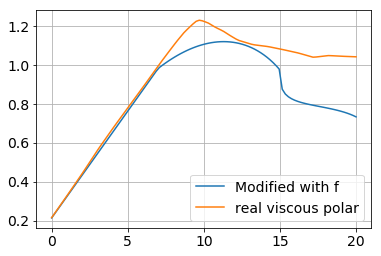

In [50]:

alpha_temp = np.linspace(0,20,100)
dCn_da = 2*np.pi
fprime_temp = np.zeros(len(alpha_temp))

for i in range(len(alpha_temp)):
    fprime_temp[i]  = f_trailing_edge_separation_point(alpha_temp[i]*np.pi/180)

alpha0 = -1.9457*np.pi/180 
cl_mod = dCn_da*((1+np.sqrt(fprime_temp))/2)**2*(alpha_temp*np.pi/180-alpha0)


cl_real=np.interp(alpha_temp,B.polar_alpha,B.polar_cl)

plt.plot(alpha_temp,cl_mod, label = 'Modified with f')
plt.plot(alpha_temp,cl_real, label = 'real viscous polar')
plt.legend()


# Case - Dyn 2

In [299]:
#create the time array
Uinf = 10 # unperturbed wind speed in m/s
max_time = 50 #upper bound on the time vector
dt = 0.1
time = np.arange(0,max_time,dt)
U1_U0 = 1.0
deltaU = 0.5
omega_r_uinf = 0.3
azimuth = TSR*Uinf/Radius*time
U_time = np.zeros(len(time)) + Uinf*U1_U0 + deltaU*np.cos(omega_r_uinf*time)*np.cos(azimuth)


In [300]:
import time as tm
#1.1 Demonstrate a fully developed cycle for case Dyn 1 
#ending ds=dynamic stall
model='pitt_peters'
dyn_stall = True
leading_edge = True
[a_res_pp_ds, ap_res_pp_ds, alpha_res_pp_ds, fnorm_res_pp_ds, ftan_res_pp_ds, Ct_res_pp_ds, 
 CT_res_pp_ds, CP_res_pp_ds, test_res_pp_ds] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)

#1.1.1 Compare with the loads assuming a steady  polar, and discuss the results
#ending sp=steady polar
model = 'pitt_peters'
dyn_stall = False
leading_edge = False
[a_res_pp_sp, ap_res_pp_sp, alpha_res_pp_sp, fnorm_res_pp_sp, ftan_res_pp_sp, Ct_res_pp_sp, 
 CT_res_pp_sp, CP_res_pp_sp, test_res_pp_sp] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)

#1.1.2 Compare with the loads assuming that there is no leading edge separation, 
#and discuss the results
#end nles=no leading edge separation
model='pitt_peters'
dyn_stall = True
leading_edge=False
[a_res_pp_nles, ap_res_pp_nles, alpha_res_pp_nles, fnorm_res_pp_nles, ftan_res_pp_nles, 
 Ct_res_pp_nles, CT_res_pp_nles, CP_res_pp_nles, 
 test_res_pp_nles] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)

# As a check, run the analysis for a steady BEM code.
model='steady'
dyn_stall = False
leading_edge = False
[a_res_s, ap_res_s, alpha_res_s, fnorm_res_s, ftan_res_s, Ct_res_s, CT_res_s, 
 CP_res_s, test_res_s] = B.get_solution(time, U_time, pitch, model, dyn_stall, leading_edge)


we are at 97.0%


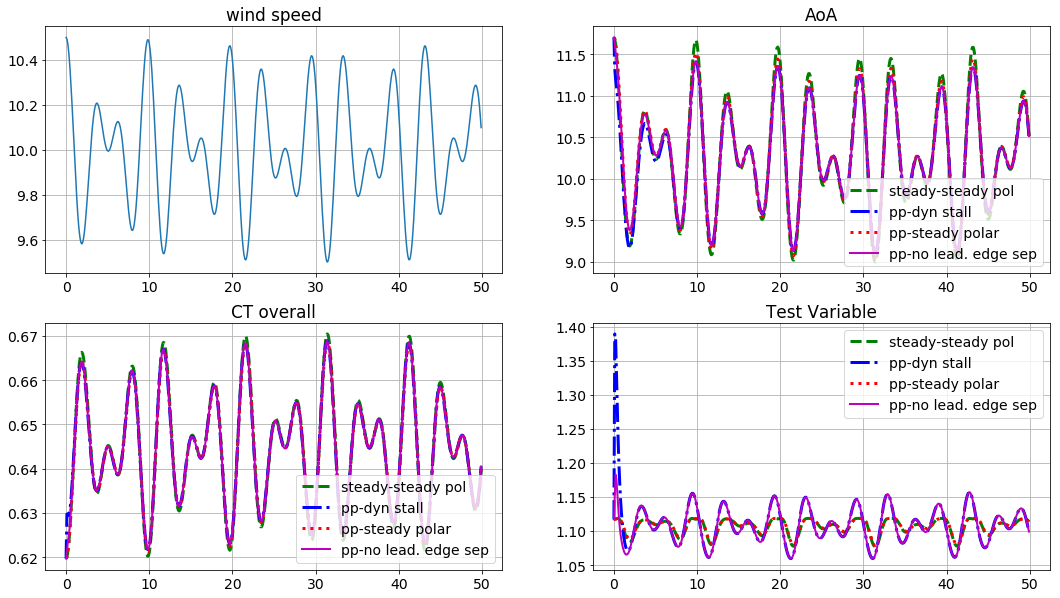

In [301]:
l = 4

show_cp = False
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 14}) 
fig, axs = plt.subplots(2,2, figsize=(18,10))
axs[0,0].plot(time, U_time)
axs[0,0].set_title('wind speed')

axs[0,1].set_title('AoA')
axs[0,1].plot(time, alpha_res_s[l,:], linestyle='--', linewidth=3, color='g', label='steady-steady pol')
axs[0,1].plot(time, alpha_res_pp_ds[l,:], linestyle='-.', linewidth=3, color='b', label='pp-dyn stall')
axs[0,1].plot(time, alpha_res_pp_sp[l,:], linestyle=':', linewidth=3, color='r', label='pp-steady polar')
axs[0,1].plot(time, alpha_res_pp_nles[l,:], linestyle='-', linewidth=2, color='m', label='pp-no lead. edge sep')
# axs[0,1].set_ylim([0.4, 1.0])
axs[0,1].legend(loc='lower right')

axs[1,0].set_title('CT overall')
axs[1,0].plot(time, CT_res_s, linestyle='--', linewidth=3, color='g', label='steady-steady pol')
axs[1,0].plot(time, CT_res_pp_ds, linestyle='-.', linewidth=3, color='b', label='pp-dyn stall')
axs[1,0].plot(time, CT_res_pp_sp, linestyle=':', linewidth=3, color='r', label='pp-steady polar')
axs[1,0].plot(time, CT_res_pp_nles, linestyle='-', linewidth=2, color='m', label='pp-no lead. edge sep')
# axs[1,0].set_ylim([0.6, 0.7])
axs[1,0].legend(loc='lower right')

axs[1,1].set_title('Test Variable')
axs[1,1].plot(time, test_res_s[l,:], linestyle='--', linewidth=3, color='g', label='steady-steady pol')
axs[1,1].plot(time, test_res_pp_ds[l,:], linestyle='-.', linewidth=3, color='b', label='pp-dyn stall')
axs[1,1].plot(time, test_res_pp_sp[l,:], linestyle=':', linewidth=3, color='r', label='pp-steady polar')
axs[1,1].plot(time, test_res_pp_nles[l,:], linestyle='-', linewidth=2, color='m', label='pp-no lead. edge sep')
# axs[1,1].set_ylim([5, 6])
axs[1,1].legend()

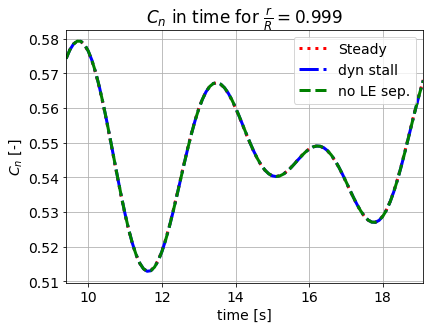

In [319]:
l = 29
i1 = 94
i2 = 192

plt.figure(figsize = [8, 4.8])
plt.plot(time[i1:i2], test_res_pp_sp[l,i1:i2], linestyle=':', linewidth=3, color='r', label='Steady')
plt.plot(time[i1:i2], test_res_pp_ds[l,i1:i2], linestyle='-.', linewidth=3, color='b', label='dyn stall')
plt.plot(time[i1:i2], test_res_pp_nles[l,i1:i2], linestyle='--', linewidth=3, color='g', label='no LE sep.')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim([time[i1],time[i2-1]])
plt.xlabel(r'time [s]')
plt.ylabel(r'$C_n$ [-]')
plt.title(r'$C_n$ in time for $\frac{{r}}{{R}} = {}$'.format(np.round(B.r_R_cent[l],3)))
plt.tight_layout()
plt.savefig('results_case2/Cn_t_ann_{}.pdf'.format(l))




# Simulate the blade over time

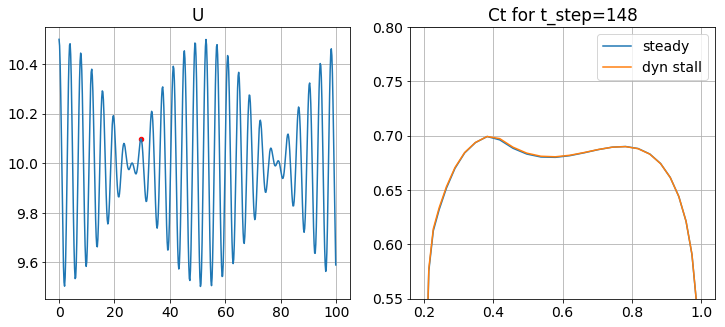

KeyboardInterrupt: 

In [247]:
import time as tm
for j in range(0,int(len(time)), 1):
    clear_output(wait=True)
    fig1, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].set_title('U')
    ax[0].plot(time, U_time)
    ax[0].scatter(time[j], U_time[j],  s=20, color='r')
    
    # Time analysis of Ct
    ax[1].set_title('Ct for t_step={}'.format(j))
    ax[1].plot(B.r_R_cent, Ct_res_s[:,j], label='steady')
    ax[1].plot(B.r_R_cent, Ct_res_pp_nles[:,j], label='dyn stall')
    ax[1].set_ylim([0.55, 0.8])
    
    # Time analysis of the test variable
#     ax[1].plot(B.r_R_cent, test_res_s[:,j], label='steady')
#     ax[1].plot(B.r_R_cent, test_res_pp_nles[:,j], label='dyn stall')
    ax[1].legend()

    plt.show()
    tm.sleep(0.2)